#### Το notebook αυτό περιέχει όλο τον κώδικα που χρησιμοποιήθηκε για την εξαγωγή των αποτελεσμάτων που πήραμε για τον συμμετέχοντα 3. Τα αποτελέσματα για τους υπόλοιπους συμμετέχοντες τα πήραμε τρέχοντας το ίδιο notebook, αλλάζοντας μόνο το αρχείο εισόδου.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

from numpy import linalg as la

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import itertools
import matplotlib.ticker as plticker

In [2]:
# This data package contains 10 anonymized datasets of scalp-recorded EEG in MATLAB (.mat) format.
# Each .mat file contains EEG data from one experimental participant.
# S1.mat - S10.mat
# These 10 .mat files contain the EEG and stimulus labels for individual participants.
# Each file combines the six EEG recordings that were taken across two experimental sessions for each participant. 
# Data matrices have been cleaned and preprocessed as described in Kaneshiro etal. (2015). 
# Each data file is around 316MB in size, for a total size of around 3.16GB.

In [3]:
mat = scipy.io.loadmat('S3.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Aug 22 19:12:58 2017',
 '__version__': '1.0',
 '__globals__': [],
 'sub': array(['S3'], dtype='<U2'),
 'Fs': array([[62.5]]),
 'N': array([[32]], dtype=uint8),
 'T': array([[5186]], dtype=uint16),
 'exemplarLabels': array([[70,  4, 53, ..., 41, 58, 29]], dtype=uint8),
 'categoryLabels': array([[6, 1, 5, ..., 4, 5, 3]], dtype=uint8),
 'X_2D': array([[-0.05816289, -0.03873367, -0.10607522, ..., -0.14795946,
         -0.13199082, -0.08302993],
        [ 0.02411839, -0.0140558 , -0.04893139, ...,  0.19886579,
          0.23924964,  0.0343092 ],
        [-0.03461225, -0.151652  ,  0.04322697, ..., -0.00411071,
          0.12195693,  0.24497362],
        ...,
        [-0.17249457,  0.08577407,  0.13699172, ..., -0.32229117,
          0.05266799,  0.07570719],
        [-0.17875738, -0.04371437, -0.13995358, ..., -0.07161093,
          0.24846987, -0.40182685],
        [-0.1240479 ,  0.17698635,  0.08735448, ..., -0.634459

In [4]:
# Experimental participant identifier (e.g., 'S1', 'S2')
sub = np.array(mat["sub"])

# Sampling frequency of the data (always 62.5Hz)
Fs = np.array(mat["Fs"])

# Number of time samples per trial (always  32)
N = np.array(mat["N"])

# Number of experimental trials (around 5,184 per dataset)
T = np.array(mat["T"])

# A vector of length T containing the exemplar label of each trial.
exemplarLabels = np.array(mat["exemplarLabels"])
 
# A vector of length T containing the category label of each trial.
# (1=Human Body; 2=Human Face; 3=Animal Body; 4=Animal Face; 5=Fruit Vegetable; 6=Inanimate Object)
categoryLabels = np.array(mat["categoryLabels"])

# The 2D EEG data matrix. 
# Size of X_2D is T rows by 124*N columns.
# Each row of X represents one experimental trial.
# These are the matrices that were input to the classifier in the Kaneshiro et al. (2015) PLoS paper.
# Trial labels are corresponding elements in the exemplarLabels and categoryLabels vectors.
# Columns of X_2D contain N time samples of EEG, concatenated from 124 electrodes
# (i.e., N time samples fromelectrode 1 followed by N time samples from electrode 2, etc.).
# Electrode numbers correspond to channels 1-124 of EGI's HydroCel Geodesic Sensor Net, 128 channels
# (ftp://ftp.egi.com/pub/support/Documents/net_layouts/hcgsn_128.pdf).
X_2D = np.array(mat["X_2D"])

# The 3D EEG data matrix. 
# X_3D is a 3-dimensional electrodes-by-time-by-trial matrix of size 124-by-32-by-T.
# Each slice of X_3D along the trial dimension representsone experimental trial.
# Trial labels are corresponding elements in the exemplarLabelsand categoryLabels vectors.
# This form of the EEG data allows for easier subsetting bytime and space.
# Electrode numbers correspond to channels 1-124 of EGI's HydroCelGeodesic Sensor Net, 128 channels
# (ftp://ftp.egi.com/pub/support/Documents/net_layouts/hcgsn_128.pdf).
X_3D = np.array(mat["X_3D"])

In [5]:
print(exemplarLabels.shape)
print(categoryLabels.shape)
print(X_2D.shape)
print(X_3D.shape)

(1, 5186)
(1, 5186)
(5186, 3968)
(124, 32, 5186)


### SVD

In [6]:
# Let the data matrix X_2D be of n x p size,
# where n is the number of samples and p is the number of variables  
n, p, k = 5188, 3968, 200
X = X_2D.copy()
y = categoryLabels.ravel()
# Let us assume that it is centered
X -= np.mean(X, axis=0)
[u,s,v] = la.svd(X) 
v = v.transpose() 

### Confusion Matrix function

In [7]:
def plot_cm(cm,n):
    if n != 72:
        fig = plt.figure(figsize=(6.5,6.5))
        ax = fig.add_subplot()
        plt.imshow(cm,cmap='Blues', interpolation='nearest')
        plt.colorbar()
        
        loc = plticker.MultipleLocator(base=1.0)
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)

        if n == 6 :
            ax.set_xticklabels([''] + ["HB", "HF", "AB", "AF", "FV", "IO"])
            ax.set_yticklabels([''] + ["HB", "HF", "AB", "AF", "FV", "IO"])
        elif n == 12 :
            ax.set_xticklabels([''] + ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
            ax.set_yticklabels([''] + ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
        elif n == 2 :
            ax.set_xticklabels([''] + ["HF", "IO"])
            ax.set_yticklabels([''] + ["HF", "IO"])
    
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center",color="white" if cm[i, j] > thresh else "black");
    
    else:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot()
        plt.imshow(cm,cmap='Blues', interpolation='nearest')
        plt.colorbar()
            
    plt.title("Confusion matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')

### LDA function

In [8]:
def lda_function(X, v, y, n):
    k_fold = KFold(10, shuffle=True)                                       
    
    accuracy_cv = np.zeros((10))
    cm_cv = np.zeros((n,n))
    j = 0
    k_max = min(200, len(X[0])) + 1                                         # kmax = min(200,K), K= length of feature vector
 
    for (train_index, test_index) in k_fold.split(X):                       # outer cross validation
        X_train, X_test = X[train_index], X[test_index]                     # define train and test sets
        y_train, y_test = y[train_index], y[test_index]
        
        k_fold_nested = KFold(10, shuffle=True)
        i = 0
    
        k_best = np.zeros((10))
        accuracy_best = np.zeros((10))
        
        #print("Nested cv -----------------")
    
        for (trn,tst) in k_fold_nested.split(X_train):                      # nested cross-validation
            X_train_nested, X_test_nested = X[trn], X[tst]                  # define train and test sets
            y_train_nested, y_test_nested = y[trn], y[tst]
        
            for k in range(3, k_max):                                       # run for all possible k
                v_new = v[:,:k]
                x_train_svd = np.dot(X_train_nested, v_new)
                x_test_svd = np.dot(X_test_nested, v_new)
            
                lda = LinearDiscriminantAnalysis()                          # train an lda model
                lda.fit(x_train_svd, y_train_nested)
                current_accuracy = lda.score(x_test_svd, y_test_nested)     # find the accuracy
                if accuracy_best[i] < current_accuracy:                     # keep the k that results to the best accuracy
                    accuracy_best[i] = current_accuracy
                    k_best[i] = k
                    
            i = i+1
        
        index = np.argmax(accuracy_best)                                    # keep the k that results to the best accuracy
        k_choice = int(k_best[index])                                       # from the inner cross-validation
        #print(k_choice)
    
        v_new = v[:,:k_choice]
        X_train_svd = np.dot(X_train, v_new)                                # reduce the dimentions of the train and test set
        X_test_svd = np.dot(X_test, v_new)
    
        lda = LinearDiscriminantAnalysis()                                  # train an lda model
        lda.fit(X_train_svd, y_train)
    
        preds = lda.predict(X_test_svd)                                     # test the model and find the accuracy
        accuracy_cv[j] = accuracy_score(y_test, preds)
        #print(accuracy_cv[j])
    
        cm = confusion_matrix(y_test, preds)                                # make the confusion matrix
        cm_cv = cm_cv + cm                                                  # add together all the confusion matrices
    
        j = j+1
     
    sum_by_row = np.sum(cm_cv, 1)                                           # normalize the final confusion matrix
    for i in range(0,n):
        cm_cv[i,:] = cm_cv[i,:] / sum_by_row[i]
        
    final_accuracy = np.mean(accuracy_cv)                                   # find the mean accuracy from the outer cv
    
    return final_accuracy, cm_cv                                            # return the finala accuracy and the final cm

### SVM function

In [9]:
def svm_function(X, v, y,n):
    k_fold = KFold(10, shuffle=True)
    
    accuracy_cv = np.zeros((10))
    cm_cv = np.zeros((n,n))
    j = 0
    k_max = min(200, len(X[0])) + 1                                         # kmax = min(200,K), K= length of feature vector

    for (train_index, test_index) in k_fold.split(X):                       # outer cross validation
        X_train, X_test = X[train_index], X[test_index]                     # define train and test sets
        y_train, y_test = y[train_index], y[test_index]
        
        k_fold_nested = KFold(10, shuffle=True)
        i = 0
    
        k_best = np.zeros((10))
        accuracy_best = np.zeros((10))
        
        #print("Nested cv -----------------")
    
        for (trn,tst) in k_fold_nested.split(X_train):                      # nested cross-validation
            X_train_nested, X_test_nested = X[trn], X[tst]                  # define train and test sets
            y_train_nested, y_test_nested = y[trn], y[tst]
        
            for k in range(3, k_max):                                       # run for all possible k
                v_new = v[:,:k]
                x_train_svd = np.dot(X_train_nested, v_new)
                x_test_svd = np.dot(X_test_nested, v_new)
            
                svc = SVC(kernel='rbf',gamma='scale')                       # train an svm-rbf model
                svc.fit(x_train_svd, y_train_nested)
                current_accuracy = svc.score(x_test_svd, y_test_nested)     # find the accuracy
                if accuracy_best[i] < current_accuracy:                     # keep the k that results to the best accuracy
                    accuracy_best[i] = current_accuracy
                    k_best[i] = k
                    
            i = i+1
        
        index = np.argmax(accuracy_best)                                    # keep the k that results to the best accuracy
        k_choice = int(k_best[index])                                       # from the inner cross-validation
        #print(k_choice)
    
        v_new = v[:,:k_choice]
        X_train_svd = np.dot(X_train, v_new)                                # reduce the dimentions of the train and test set
        X_test_svd = np.dot(X_test, v_new)
    
        svc = SVC(kernel='rbf',gamma='scale')                               # train an svm-rbf model
        svc.fit(X_train_svd, y_train)
    
        preds = svc.predict(X_test_svd)                                     # test the model and find the accuracy
        accuracy_cv[j] = accuracy_score(y_test, preds)
        #print(accuracy_cv[j])
    
        cm = confusion_matrix(y_test, preds)                                # make the confusion matrix
        cm_cv = cm_cv + cm                                                  # add together all the confusion matrices
    
        j = j+1
    
    sum_by_row = np.sum(cm_cv, 1)                                           # normalize the final confusion matrix
    for i in range(0,n):
        cm_cv[i,:] = cm_cv[i,:] / sum_by_row[i]
        
    final_accuracy = np.mean(accuracy_cv)                                   # find the mean accuracy from the outer cv
    
    return final_accuracy, cm_cv                                            # return the finala accuracy and the final cm

## All 6 classes - Compare LDA with SVM

Total time of classification process using LDA: 5976.122375011444 seconds

Final Accuracy is: 39.452%


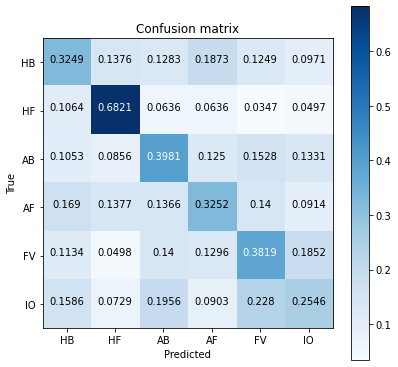

In [14]:
start_time = time.time()

lda_accuracy, lda_cm = lda_function(X, v, y,6)

print("Total time of classification process using LDA: %s seconds" % (time.time() - start_time))
print("\nFinal Accuracy is: {:.3%}" .format(lda_accuracy))  
plot_cm(np.round(lda_cm, 4),6)

Total time of classification process using SVM: 122152.77758145332 seconds

Final Accuracy is: 37.471%


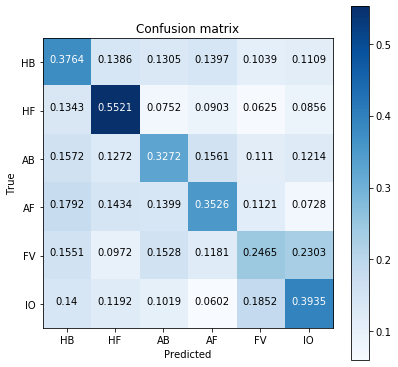

In [1]:
start_time = time.time()

svm_accuracy, svm_cm = svm_function(X, v, y,6)

print("Total time of classification process using SVM: %s seconds" % (time.time() - start_time))
print("\nFinal Accuracy is: {:.3%}" .format(svm_accuracy))  
plot_cm(np.round(svm_cm, 4),6)

### Spatial subsets

In [15]:
X_spatial = X_3D.copy()

spatial_accuracy = np.zeros((124))

for i in range(0,124):                                       # for each electrode
    X = X_spatial[i].transpose()
    
    X -= np.mean(X, axis=0)                                  # svd
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X, v, y,6)          # use lda function to find the accuracy and the cm
    spatial_accuracy[i] = final_accuracy
    
    print("Final Accuracy of electrode {} is: {:.3%}" .format(i+1, final_accuracy))
    
    # plot_cm(np.round(cm_cv, 4),6)

Final Accuracy of electrode 1 is: 23.641%
Final Accuracy of electrode 2 is: 21.288%
Final Accuracy of electrode 3 is: 25.589%
Final Accuracy of electrode 4 is: 26.745%
Final Accuracy of electrode 5 is: 25.222%
Final Accuracy of electrode 6 is: 25.724%
Final Accuracy of electrode 7 is: 25.588%
Final Accuracy of electrode 8 is: 20.863%
Final Accuracy of electrode 9 is: 23.622%
Final Accuracy of electrode 10 is: 28.058%
Final Accuracy of electrode 11 is: 27.496%
Final Accuracy of electrode 12 is: 25.782%
Final Accuracy of electrode 13 is: 26.417%
Final Accuracy of electrode 14 is: 21.230%
Final Accuracy of electrode 15 is: 24.238%
Final Accuracy of electrode 16 is: 26.726%
Final Accuracy of electrode 17 is: 20.304%
Final Accuracy of electrode 18 is: 28.115%
Final Accuracy of electrode 19 is: 26.899%
Final Accuracy of electrode 20 is: 23.486%
Final Accuracy of electrode 21 is: 20.844%
Final Accuracy of electrode 22 is: 24.027%
Final Accuracy of electrode 23 is: 24.471%
Final Accuracy of el

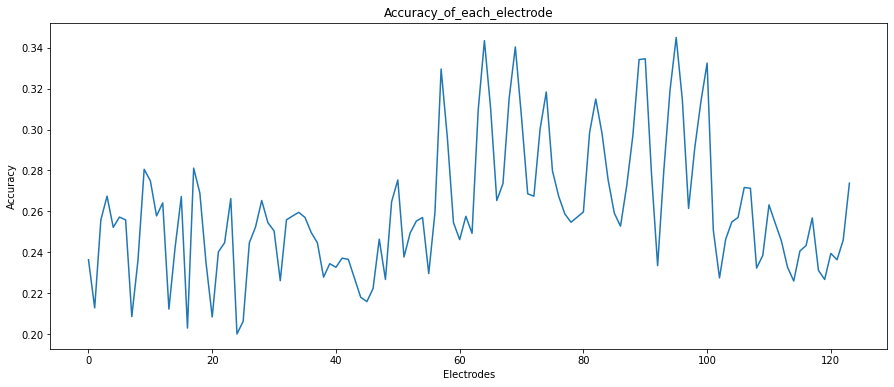

In [16]:
fig = plt.figure(figsize=(15,6))
plt.plot(spatial_accuracy)
plt.title("Accuracy_of_each_electrode")
plt.ylabel('Accuracy')
plt.xlabel('Electrodes')
plt.show()

### temporal subsets

Παίρνουμε παράθυρα από 5 samples, κάθε 3 samples. Δηλαδή:

παράθυρο 1: samples 1-5 

παράθυρο 2: samples 4-8 

.

.

.

Κάθε sample έχει 15.5ms. Τα τρία περίπου 48ms. Τα 5 samples περίπου 80ms. Τρέχουμε τον κώδικα για τα 9 παράθυρα (από τα 10, όπως στο paper).

Final Accuracy of time window 0-4 is: 16.776%
Final Accuracy of time window 3-7 is: 18.762%
Final Accuracy of time window 6-10 is: 29.696%
Final Accuracy of time window 9-13 is: 35.866%
Final Accuracy of time window 12-16 is: 35.982%
Final Accuracy of time window 15-19 is: 34.574%
Final Accuracy of time window 18-22 is: 31.565%
Final Accuracy of time window 21-25 is: 28.576%
Final Accuracy of time window 24-28 is: 30.524%


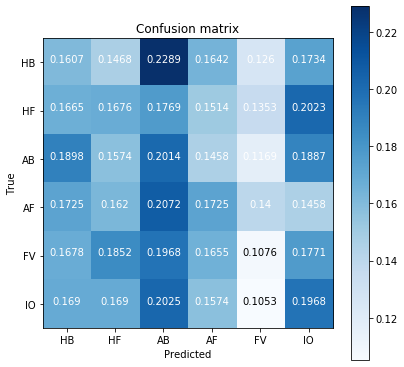

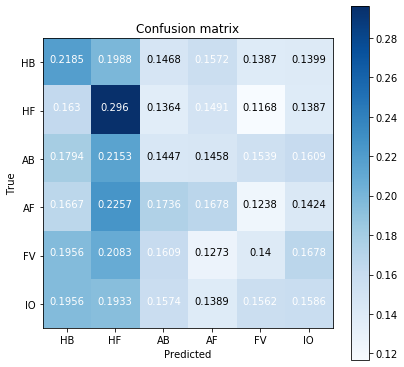

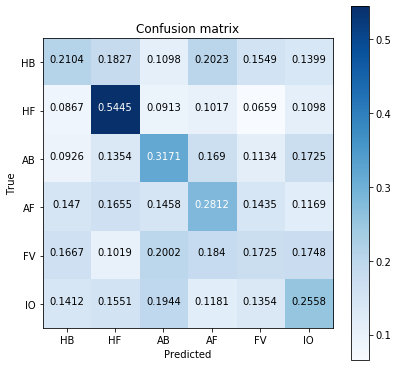

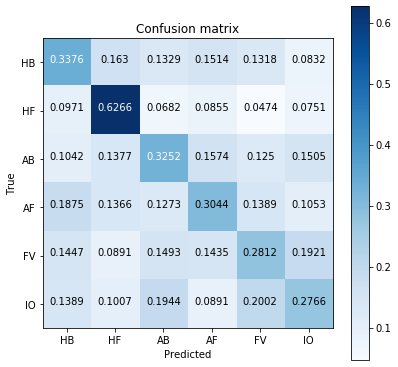

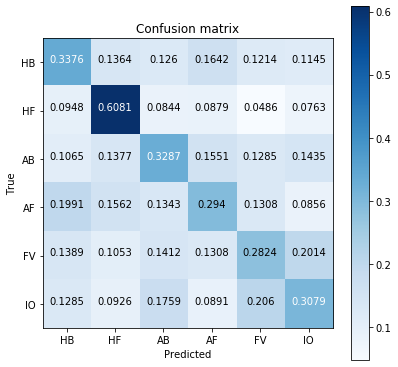

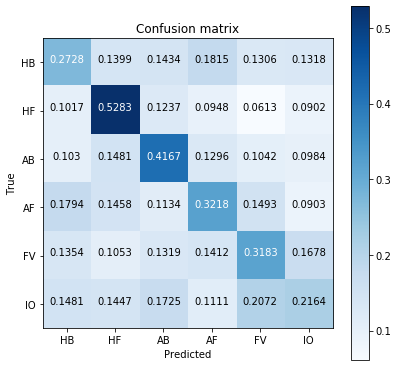

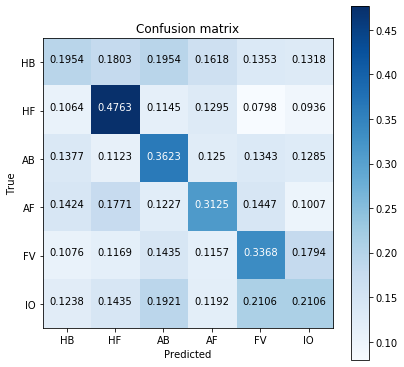

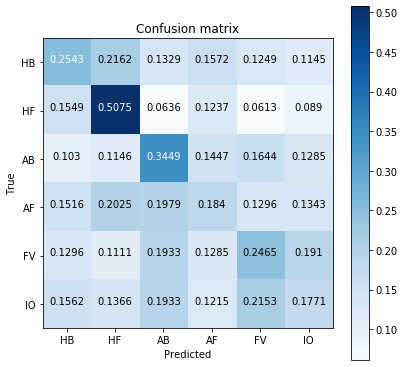

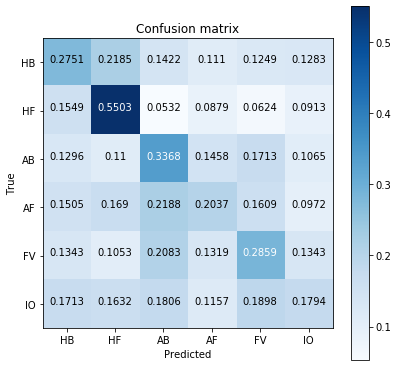

In [11]:
X_temporal = X_3D.copy()
X_temporal = np.transpose(X_temporal, (1, 2, 0))                # 32 x 5184 x 124

keep_cm = []

for i in range(0,25,3):                                         # for each time window
    X = np.concatenate((X_temporal[i], X_temporal[i+1], X_temporal[i+2], X_temporal[i+3], X_temporal[i+4]), axis=1)
    
    X -= np.mean(X, axis=0)                                     # svd
    [u,s,v] = la.svd(X)  
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X,v,y,6)               # use lda function to find the accuracy and the cm
    
    print("Final Accuracy of time window {}-{} is: {:.3%}" .format(i, i+4, final_accuracy))
    
    keep_cm.append(cm_cv)
    
    plot_cm(np.round(cm_cv, 4),6)

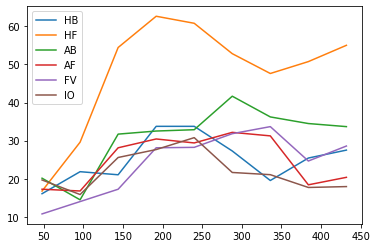

In [12]:
diag = []

for i in range(0,6):
    diag_cm = [ (keep_cm[j][i][i]*100) for j in range(len(keep_cm)) ]
    diag.append(diag_cm)

legends = ["HB", "HF", "AB", "AF", "FV", "IO"]

x = np.arange(48, 433,48)
        
for i in range(0,6):
    plt.plot(x, diag[i])

plt.legend(legends, loc='upper left')

plt.show()

### spatial and temporal subsets

In [10]:
X_sp_temp = X_3D.copy()
X_sp_temp = np.transpose(X_sp_temp, (1, 0, 2))                # 32 x 124 x 5184

spatial_temporal_accuracy = np.zeros((9,124))
length = len(X_sp_temp[0][0])
r = 0

for i in range(0,25,3):                                       # for each time window
    for j in range(0,124):                                    # for each electrode
        X = np.concatenate((np.reshape(X_sp_temp[i,j], (length,1)), np.reshape(X_sp_temp[i+1,j], (length,1)), 
                            np.reshape(X_sp_temp[i+2,j], (length,1)), np.reshape(X_sp_temp[i+3,j], (length,1)), 
                            np.reshape(X_sp_temp[i+4,j], (length,1))), axis=1)
        
        X -= np.mean(X, axis=0)                               # svd
        [u,s,v] = la.svd(X) 
        v = v.transpose() 
    
        final_accuracy, cm_cv = lda_function(X, v, y,6)       # use lda function to find the accuracy and the cm
        spatial_temporal_accuracy[r,j] = final_accuracy
    
        print("Final Accuracy of time window {}-{} and electrode {} is : {:.3%}" .format(i, i+4, j, final_accuracy))
    
        # plot_cm(np.round(cm_cv, 4),6)
    r = r+1

Final Accuracy of time window 0-4 and electrode 0 is : 16.216%
Final Accuracy of time window 0-4 and electrode 1 is : 16.062%
Final Accuracy of time window 0-4 and electrode 2 is : 16.313%
Final Accuracy of time window 0-4 and electrode 3 is : 16.217%
Final Accuracy of time window 0-4 and electrode 4 is : 16.390%
Final Accuracy of time window 0-4 and electrode 5 is : 17.315%
Final Accuracy of time window 0-4 and electrode 6 is : 16.082%
Final Accuracy of time window 0-4 and electrode 7 is : 15.561%
Final Accuracy of time window 0-4 and electrode 8 is : 17.104%
Final Accuracy of time window 0-4 and electrode 9 is : 16.930%
Final Accuracy of time window 0-4 and electrode 10 is : 16.332%
Final Accuracy of time window 0-4 and electrode 11 is : 16.390%
Final Accuracy of time window 0-4 and electrode 12 is : 16.930%
Final Accuracy of time window 0-4 and electrode 13 is : 15.253%
Final Accuracy of time window 0-4 and electrode 14 is : 16.159%
Final Accuracy of time window 0-4 and electrode 15

## Within-Category Classifications

Κάνουμε πρώτα exemplar-level (12 κλάσεις) classifications σε κάθε μία από τις κατηγορίες Human Face και Inanimate Object και μετά κάνουμε Human Face versus Inanimate Object (2 κλάσεις).

Για την Human Face έχουμε ότι οι exemplar level κλάσεις έχουν τιμές από 13 μέχρι και 24.

Για την Inanimate Object έχουμε ότι οι exemplar level κλάσεις έχουν τιμές από 61 μέχρι και 72.

In [13]:
y1 = categoryLabels.ravel()
y2 = exemplarLabels.ravel()
X_3D_copy = X_3D.copy()
X_3D_copy = np.transpose(X_3D_copy, (2, 0, 1))                  # 5184 x 124 x 32

X_hf = []
X_io = []
X_hf_io = []
X_hf_3d = []
X_io_3d = []
X_hf_io_3d = []
y_hf = []
y_io = []
y_hf_io = []

for i in range(0,len(X_2D)):                                    # create all the matrices needed
    if (12 < y2[i] < 25):
        y_hf.append(y2[i])
        y_hf_io.append(y1[i])
        X_hf.append(X_2D[i])
        X_hf_io.append(X_2D[i])
        X_hf_3d.append(X_3D_copy[i])
        X_hf_io_3d.append(X_3D_copy[i])
    elif 60 < y2[i]:
        y_io.append(y2[i])
        y_hf_io.append(y1[i])
        X_io.append(X_2D[i])
        X_hf_io.append(X_2D[i])
        X_io_3d.append(X_3D_copy[i])
        X_hf_io_3d.append(X_3D_copy[i])

X_hf = np.array(X_hf)
X_io = np.array(X_io)
X_hf_io = np.array(X_hf_io)
X_hf_3d = np.array(X_hf_3d)
X_hf_3d = np.transpose(X_hf_3d, (1,2,0))                      # 124 x 32 x 864
X_io_3d = np.array(X_io_3d)
X_io_3d = np.transpose(X_io_3d, (1,2,0))
X_hf_io_3d = np.array(X_hf_io_3d)
X_hf_io_3d = np.transpose(X_hf_io_3d, (1,2,0))
y_hf = np.array(y_hf)
y_io = np.array(y_io)
y_hf_io = np.array(y_hf_io)

### human face - classification


Final Accuracy is: 16.423%


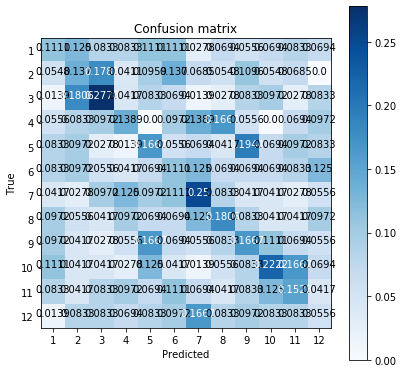

In [14]:
X = X_hf.copy()
X -= np.mean(X, axis=0)                                         # svd
[u,s,v] = la.svd(X) 
v = v.transpose()

lda_accuracy, lda_cm = lda_function(X, v, y_hf,12)              # use lda function to find the accuracy and the cm

print("\nFinal Accuracy is: {:.3%}" .format(lda_accuracy))  
plot_cm(np.round(lda_cm, 4),12)

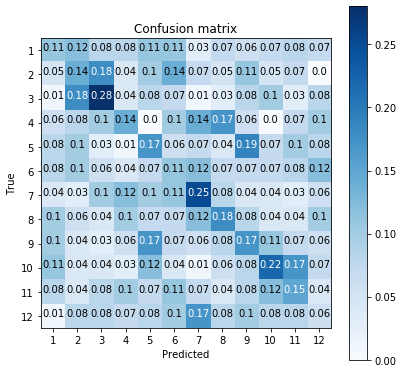

In [15]:
plot_cm(np.round(lda_cm, 2),12)

### Spatial subsets

In [16]:
X_spatial = X_hf_3d.copy()

spatial_accuracy = np.zeros((124))

for i in range(0,124):                                           # for each electrode
    X = X_spatial[i].transpose()
    
    X -= np.mean(X, axis=0)                                      # svd
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X, v, y_hf,12)          # use lda function to find the accuracy and the cm
    spatial_accuracy[i] = final_accuracy
    
    print("Final Accuracy of electrode {} is: {:.3%}" .format(i+1, final_accuracy))
    
    # plot_cm(np.round(cm_cv, 4),12)

Final Accuracy of electrode 1 is: 9.944%
Final Accuracy of electrode 2 is: 9.018%
Final Accuracy of electrode 3 is: 9.018%
Final Accuracy of electrode 4 is: 11.091%
Final Accuracy of electrode 5 is: 12.705%
Final Accuracy of electrode 6 is: 11.445%
Final Accuracy of electrode 7 is: 12.380%
Final Accuracy of electrode 8 is: 7.866%
Final Accuracy of electrode 9 is: 8.317%
Final Accuracy of electrode 10 is: 11.215%
Final Accuracy of electrode 11 is: 12.032%
Final Accuracy of electrode 12 is: 12.032%
Final Accuracy of electrode 13 is: 12.482%
Final Accuracy of electrode 14 is: 9.592%
Final Accuracy of electrode 15 is: 10.523%
Final Accuracy of electrode 16 is: 12.129%
Final Accuracy of electrode 17 is: 11.222%
Final Accuracy of electrode 18 is: 13.999%
Final Accuracy of electrode 19 is: 11.210%
Final Accuracy of electrode 20 is: 11.914%
Final Accuracy of electrode 21 is: 10.861%
Final Accuracy of electrode 22 is: 8.903%
Final Accuracy of electrode 23 is: 10.739%
Final Accuracy of electrode

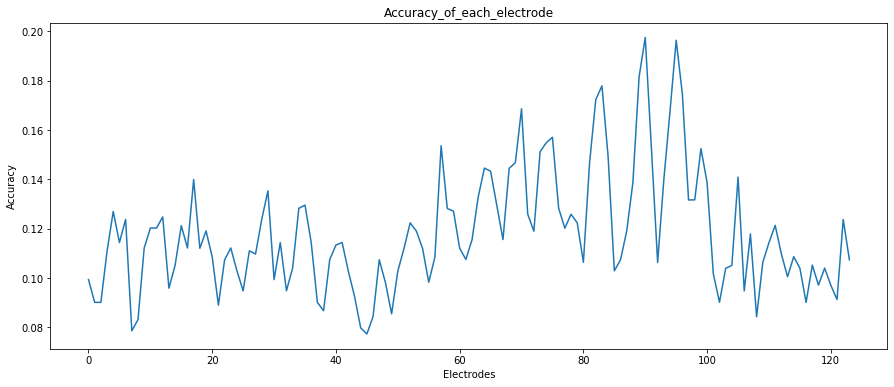

In [17]:
fig = plt.figure(figsize=(15,6))
plt.plot(spatial_accuracy)
plt.title("Accuracy_of_each_electrode")
plt.ylabel('Accuracy')
plt.xlabel('Electrodes')
plt.show()

### Temporal subsets

Final Accuracy of time window 0-4 is: 8.561%
Final Accuracy of time window 3-7 is: 9.477%
Final Accuracy of time window 6-10 is: 10.740%
Final Accuracy of time window 9-13 is: 16.188%
Final Accuracy of time window 12-16 is: 17.233%
Final Accuracy of time window 15-19 is: 14.574%
Final Accuracy of time window 18-22 is: 14.912%
Final Accuracy of time window 21-25 is: 13.291%
Final Accuracy of time window 24-28 is: 9.829%


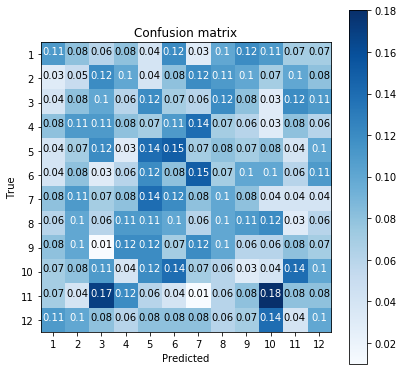

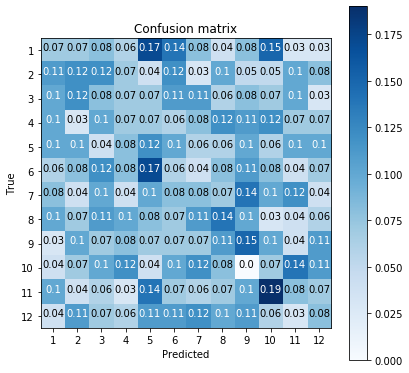

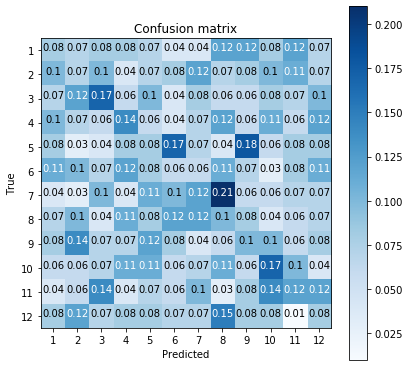

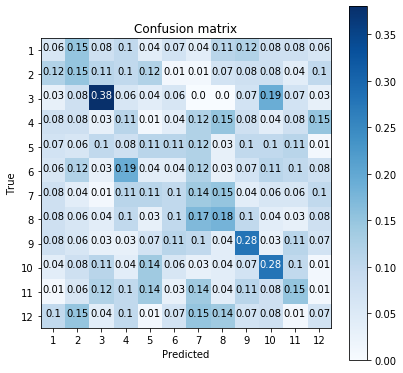

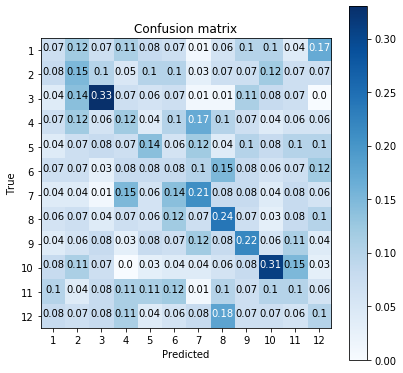

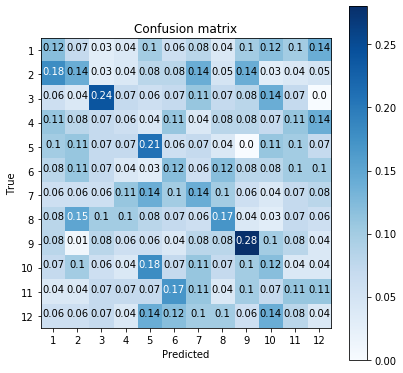

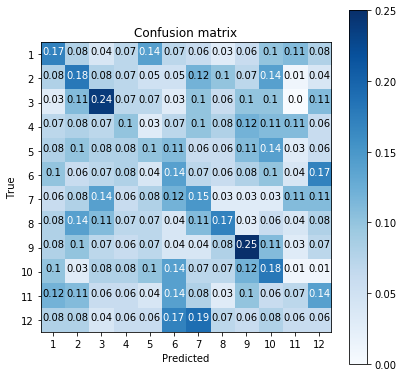

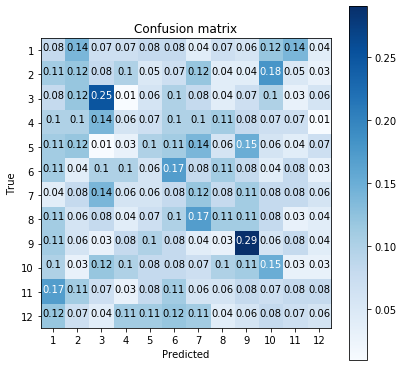

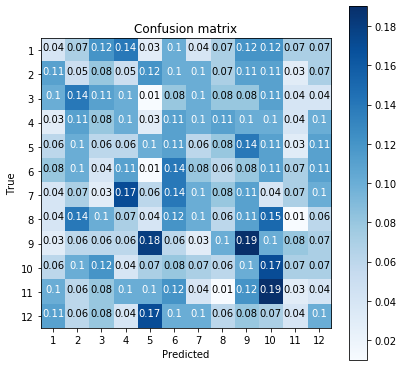

In [18]:
X_temporal = X_hf_3d.copy()
X_temporal = np.transpose(X_temporal, (1, 2, 0))                # 32 x 864 x 124

keep_cm = []

for i in range(0,25,3):                                         # for each time window
    X = np.concatenate((X_temporal[i], X_temporal[i+1], X_temporal[i+2], X_temporal[i+3], X_temporal[i+4]), axis=1)
    
    X -= np.mean(X, axis=0)                                     # svd
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X,v,y_hf,12)           # use lda function to find the accuracy and the cm
    
    print("Final Accuracy of time window {}-{} is: {:.3%}" .format(i, i+4, final_accuracy))
    
    keep_cm.append(cm_cv)
    
    plot_cm(np.round(cm_cv, 2),12)

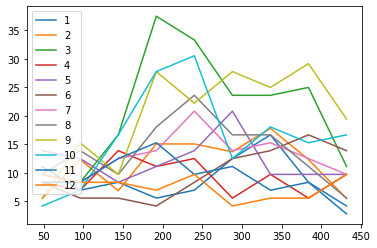

In [19]:
diag = []

for i in range(0,12):
    diag_cm = [ (keep_cm[j][i][i]*100) for j in range(len(keep_cm)) ]
    diag.append(diag_cm)

legends = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

x = np.arange(48, 433,48)
        
for i in range(0,12):
    plt.plot(x, diag[i])

plt.legend(legends, loc='upper left')

plt.show()

### Spatial and Temporal subsets

In [20]:
X_sp_temp = X_hf_3d.copy()
X_sp_temp = np.transpose(X_sp_temp, (1, 0, 2))                # 32 x 124 x 864

spatial_temporal_accuracy = np.zeros((9,124))
length = len(X_sp_temp[0][0])
r = 0

for i in range(0,25,3):                                       # for each time window
    for j in range(0,124):                                    # for each electrode
        X = np.concatenate((np.reshape(X_sp_temp[i,j], (length,1)), np.reshape(X_sp_temp[i+1,j], (length,1)), 
                            np.reshape(X_sp_temp[i+2,j], (length,1)), np.reshape(X_sp_temp[i+3,j], (length,1)), 
                            np.reshape(X_sp_temp[i+4,j], (length,1))), axis=1)
        
        X -= np.mean(X, axis=0)                               # svd
        [u,s,v] = la.svd(X) 
        v = v.transpose() 
    
        final_accuracy, cm_cv = lda_function(X, v, y_hf, 12)  # use lda function to find the accuracy and the cm
        spatial_temporal_accuracy[r,j] = final_accuracy
    
        print("Final Accuracy of time window {}-{} and electrode {} is : {:.3%}" .format(i, i+4, j, final_accuracy))
    
        # plot_cm(np.round(cm_cv, 4),12)
    r = r+1

Final Accuracy of time window 0-4 and electrode 0 is : 6.590%
Final Accuracy of time window 0-4 and electrode 1 is : 5.664%
Final Accuracy of time window 0-4 and electrode 2 is : 6.577%
Final Accuracy of time window 0-4 and electrode 3 is : 7.395%
Final Accuracy of time window 0-4 and electrode 4 is : 7.394%
Final Accuracy of time window 0-4 and electrode 5 is : 8.091%
Final Accuracy of time window 0-4 and electrode 6 is : 6.935%
Final Accuracy of time window 0-4 and electrode 7 is : 7.753%
Final Accuracy of time window 0-4 and electrode 8 is : 6.124%
Final Accuracy of time window 0-4 and electrode 9 is : 6.838%
Final Accuracy of time window 0-4 and electrode 10 is : 8.325%
Final Accuracy of time window 0-4 and electrode 11 is : 9.722%
Final Accuracy of time window 0-4 and electrode 12 is : 6.823%
Final Accuracy of time window 0-4 and electrode 13 is : 7.044%
Final Accuracy of time window 0-4 and electrode 14 is : 6.815%
Final Accuracy of time window 0-4 and electrode 15 is : 8.678%
Fi

### inanimate object - classification


Final Accuracy is: 29.052%


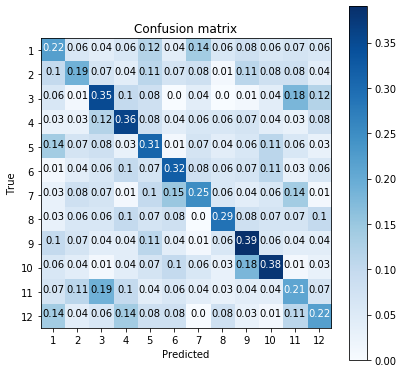

In [21]:
X = X_io.copy()
X -= np.mean(X, axis=0)                                        # svd
[u,s,v] = la.svd(X)  
v = v.transpose()

lda_accuracy, lda_cm = lda_function(X, v, y_io,12)             # use lda function to find the accuracy and the cm

print("\nFinal Accuracy is: {:.3%}" .format(lda_accuracy))  
plot_cm(np.round(lda_cm, 2),12)

### Spatial Subsets

In [22]:
X_spatial = X_io_3d.copy()

spatial_accuracy = np.zeros((124))

for i in range(0,124):                                            # for each electrode
    X = X_spatial[i].transpose() 
    
    X -= np.mean(X, axis=0)                                       # svd
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X, v, y_io,12)           # use lda function to find the accuracy and the cm
    spatial_accuracy[i] = final_accuracy
    
    print("Final Accuracy of electrode {} is: {:.3%}" .format(i+1, final_accuracy))
    
    # plot_cm(np.round(cm_cv, 4),12)

Final Accuracy of electrode 1 is: 11.818%
Final Accuracy of electrode 2 is: 10.878%
Final Accuracy of electrode 3 is: 13.780%
Final Accuracy of electrode 4 is: 12.840%
Final Accuracy of electrode 5 is: 13.189%
Final Accuracy of electrode 6 is: 17.018%
Final Accuracy of electrode 7 is: 13.539%
Final Accuracy of electrode 8 is: 11.451%
Final Accuracy of electrode 9 is: 12.160%
Final Accuracy of electrode 10 is: 13.545%
Final Accuracy of electrode 11 is: 15.513%
Final Accuracy of electrode 12 is: 13.764%
Final Accuracy of electrode 13 is: 15.857%
Final Accuracy of electrode 14 is: 10.078%
Final Accuracy of electrode 15 is: 12.378%
Final Accuracy of electrode 16 is: 16.673%
Final Accuracy of electrode 17 is: 10.313%
Final Accuracy of electrode 18 is: 16.443%
Final Accuracy of electrode 19 is: 18.975%
Final Accuracy of electrode 20 is: 15.738%
Final Accuracy of electrode 21 is: 11.812%
Final Accuracy of electrode 22 is: 11.454%
Final Accuracy of electrode 23 is: 12.503%
Final Accuracy of el

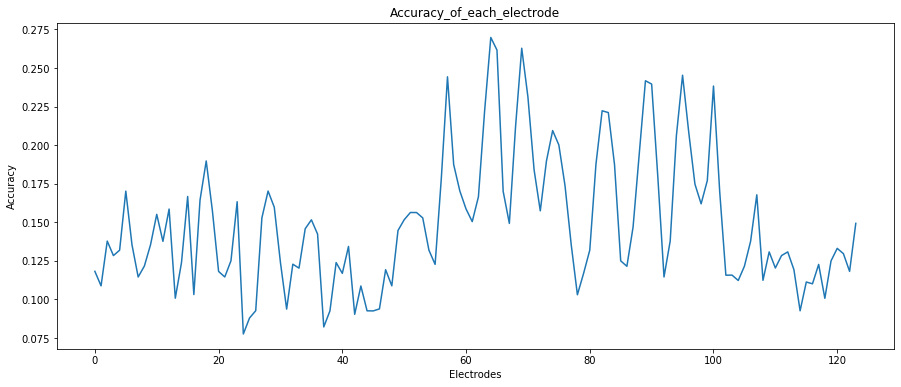

In [23]:
fig = plt.figure(figsize=(15,6))
plt.plot(spatial_accuracy)
plt.title("Accuracy_of_each_electrode")
plt.ylabel('Accuracy')
plt.xlabel('Electrodes')
plt.show()

### Temporal Subsets

Final Accuracy of time window 0-4 is: 8.341%
Final Accuracy of time window 3-7 is: 10.303%
Final Accuracy of time window 6-10 is: 18.867%
Final Accuracy of time window 9-13 is: 27.080%
Final Accuracy of time window 12-16 is: 27.430%
Final Accuracy of time window 15-19 is: 27.521%
Final Accuracy of time window 18-22 is: 17.711%
Final Accuracy of time window 21-25 is: 14.006%
Final Accuracy of time window 24-28 is: 13.095%


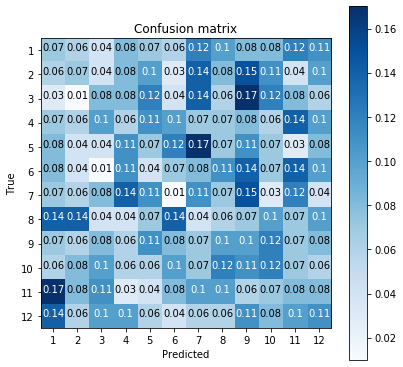

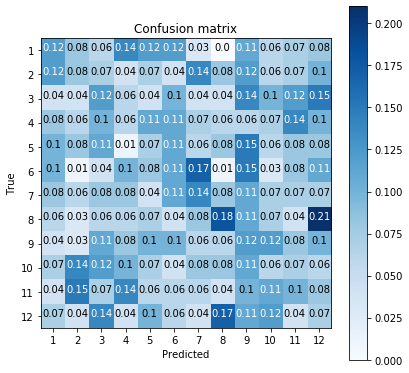

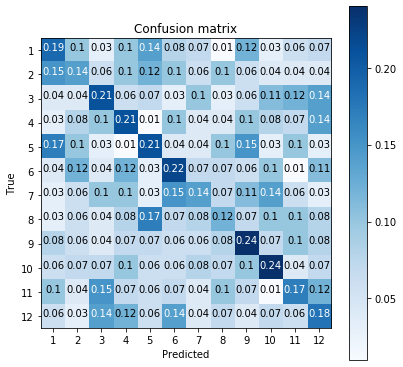

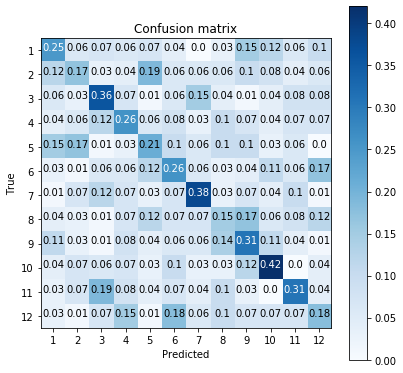

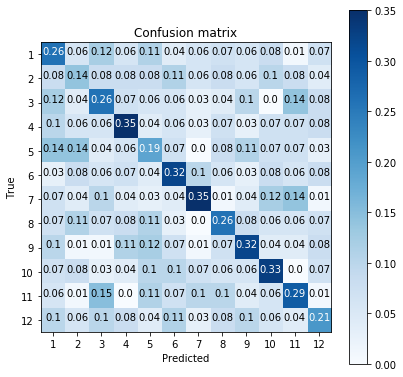

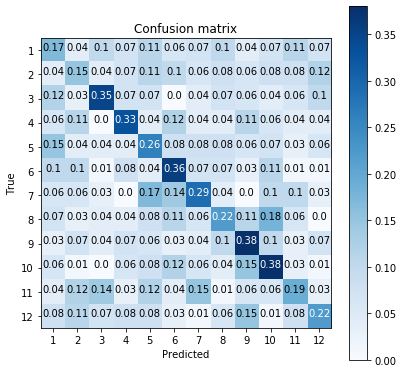

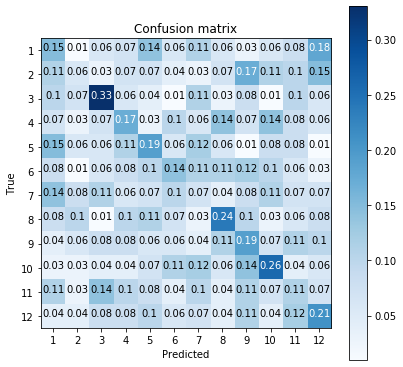

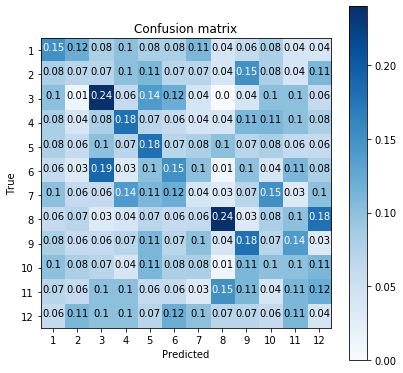

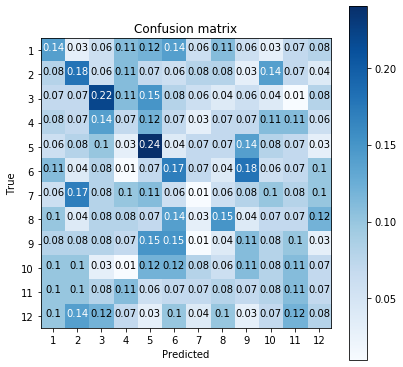

In [24]:
X_temporal = X_io_3d.copy()
X_temporal = np.transpose(X_temporal, (1, 2, 0))                # 32 x 864 x 124

keep_cm = []

for i in range(0,25,3):                                         # for each time window
    X = np.concatenate((X_temporal[i], X_temporal[i+1], X_temporal[i+2], X_temporal[i+3], X_temporal[i+4]), axis=1)
    
    X -= np.mean(X, axis=0)
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X,v,y_io,12)           # use lda function to find the accuracy and the cm
    
    print("Final Accuracy of time window {}-{} is: {:.3%}" .format(i, i+4, final_accuracy))
    
    keep_cm.append(cm_cv)
    
    plot_cm(np.round(cm_cv, 2),12)

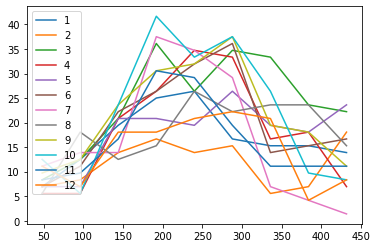

In [25]:
diag = []

for i in range(0,12):
    diag_cm = [ (keep_cm[j][i][i]*100) for j in range(len(keep_cm)) ]
    diag.append(diag_cm)

legends = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

x = np.arange(48, 433,48)
        
for i in range(0,12):
    plt.plot(x, diag[i])

plt.legend(legends, loc='upper left')

plt.show()

### Spatial and Temporal subsets

In [26]:
X_sp_temp = X_io_3d.copy()
X_sp_temp = np.transpose(X_sp_temp, (1, 0, 2))                # 32 x 124 x 864

spatial_temporal_accuracy = np.zeros((9,124))
length = len(X_sp_temp[0][0])
r = 0

for i in range(0,25,3):                                       # for each time window
    for j in range(0,124):                                    # for each electrode
        X = np.concatenate((np.reshape(X_sp_temp[i,j], (length,1)), np.reshape(X_sp_temp[i+1,j], (length,1)), 
                            np.reshape(X_sp_temp[i+2,j], (length,1)), np.reshape(X_sp_temp[i+3,j], (length,1)), 
                            np.reshape(X_sp_temp[i+4,j], (length,1))), axis=1)
        
        X -= np.mean(X, axis=0)                               # svd
        [u,s,v] = la.svd(X)  
        v = v.transpose() 
    
        final_accuracy, cm_cv = lda_function(X, v, y_io, 12)  # use lda function to find the accuracy and the cm
        spatial_temporal_accuracy[r,j] = final_accuracy
    
        print("Final Accuracy of time window {}-{} and electrode {} is : {:.3%}" .format(i, i+4, j, final_accuracy))
    
        # plot_cm(np.round(cm_cv, 4),12)
    r = r+1

Final Accuracy of time window 0-4 and electrode 0 is : 6.361%
Final Accuracy of time window 0-4 and electrode 1 is : 6.131%
Final Accuracy of time window 0-4 and electrode 2 is : 7.294%
Final Accuracy of time window 0-4 and electrode 3 is : 6.719%
Final Accuracy of time window 0-4 and electrode 4 is : 7.407%
Final Accuracy of time window 0-4 and electrode 5 is : 8.801%
Final Accuracy of time window 0-4 and electrode 6 is : 9.730%
Final Accuracy of time window 0-4 and electrode 7 is : 7.753%
Final Accuracy of time window 0-4 and electrode 8 is : 6.946%
Final Accuracy of time window 0-4 and electrode 9 is : 7.406%
Final Accuracy of time window 0-4 and electrode 10 is : 6.367%
Final Accuracy of time window 0-4 and electrode 11 is : 7.880%
Final Accuracy of time window 0-4 and electrode 12 is : 6.365%
Final Accuracy of time window 0-4 and electrode 13 is : 6.596%
Final Accuracy of time window 0-4 and electrode 14 is : 6.132%
Final Accuracy of time window 0-4 and electrode 15 is : 7.407%
Fi

### Human face vs Inanimate object - classification


Final Accuracy is: 82.012%


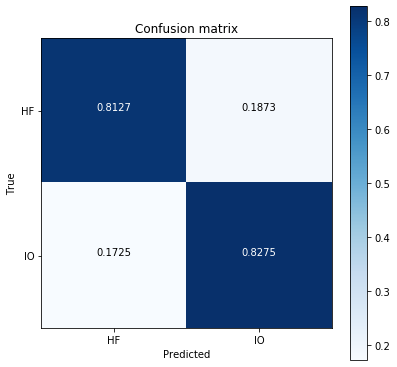

In [27]:
X = X_hf_io.copy()
X -= np.mean(X, axis=0)                                   # svd
[u,s,v] = la.svd(X) 
v = v.transpose()

lda_accuracy, lda_cm = lda_function(X, v, y_hf_io,2)      # use lda function to find the accuracy and the cm

print("\nFinal Accuracy is: {:.3%}" .format(lda_accuracy))  
plot_cm(np.round(lda_cm, 4),2)

### Spatial subsets

In [28]:
X_spatial = X_hf_io_3d.copy()

spatial_accuracy = np.zeros((124))

for i in range(0,124):                                          # for each electrode
    X = X_spatial[i].transpose()
    
    X -= np.mean(X, axis=0)                                     # svd
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X, v, y_hf_io, 2)      # use lda function to find the accuracy and the cm
    spatial_accuracy[i] = final_accuracy
    
    print("Final Accuracy of electrode {} is: {:.3%}" .format(i+1, final_accuracy))
    
    # plot_cm(np.round(cm_cv, 4),2)

Final Accuracy of electrode 1 is: 65.237%
Final Accuracy of electrode 2 is: 63.675%
Final Accuracy of electrode 3 is: 65.531%
Final Accuracy of electrode 4 is: 66.105%
Final Accuracy of electrode 5 is: 66.107%
Final Accuracy of electrode 6 is: 66.284%
Final Accuracy of electrode 7 is: 68.650%
Final Accuracy of electrode 8 is: 58.009%
Final Accuracy of electrode 9 is: 61.419%
Final Accuracy of electrode 10 is: 66.688%
Final Accuracy of electrode 11 is: 67.960%
Final Accuracy of electrode 12 is: 68.076%
Final Accuracy of electrode 13 is: 67.726%
Final Accuracy of electrode 14 is: 54.253%
Final Accuracy of electrode 15 is: 62.868%
Final Accuracy of electrode 16 is: 67.263%
Final Accuracy of electrode 17 is: 56.334%
Final Accuracy of electrode 18 is: 68.591%
Final Accuracy of electrode 19 is: 68.195%
Final Accuracy of electrode 20 is: 66.801%
Final Accuracy of electrode 21 is: 56.740%
Final Accuracy of electrode 22 is: 61.944%
Final Accuracy of electrode 23 is: 65.643%
Final Accuracy of el

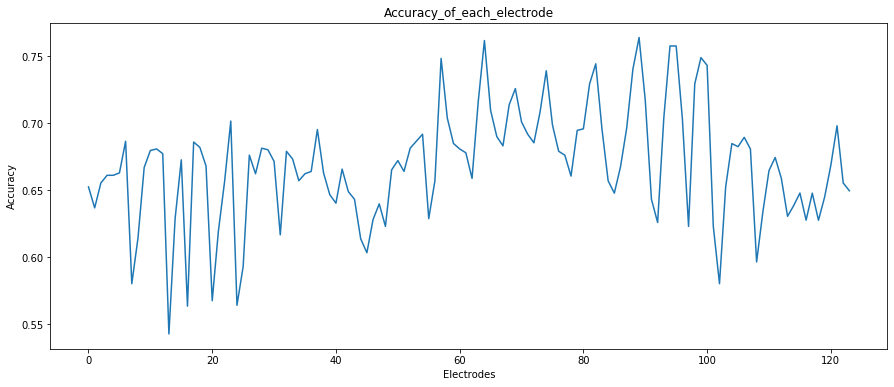

In [29]:
fig = plt.figure(figsize=(15,6))
plt.plot(spatial_accuracy)
plt.title("Accuracy_of_each_electrode")
plt.ylabel('Accuracy')
plt.xlabel('Electrodes')
plt.show()

### Temporal Subsets

Final Accuracy of time window 0-4 is: 51.413%
Final Accuracy of time window 3-7 is: 56.392%
Final Accuracy of time window 6-10 is: 70.791%
Final Accuracy of time window 9-13 is: 76.574%
Final Accuracy of time window 12-16 is: 78.311%
Final Accuracy of time window 15-19 is: 71.082%
Final Accuracy of time window 18-22 is: 68.655%
Final Accuracy of time window 21-25 is: 73.565%
Final Accuracy of time window 24-28 is: 71.256%


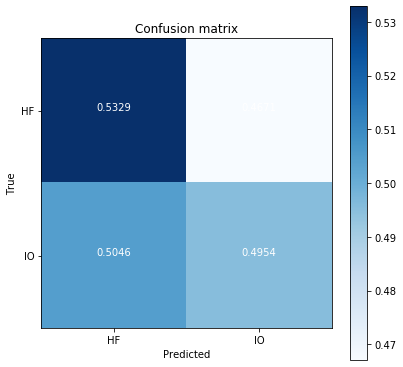

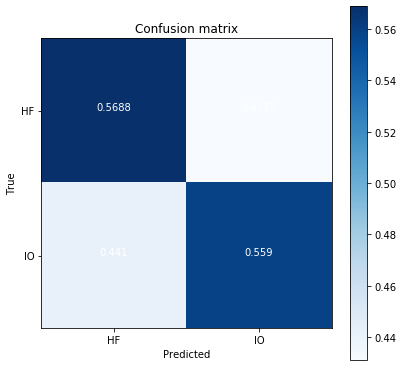

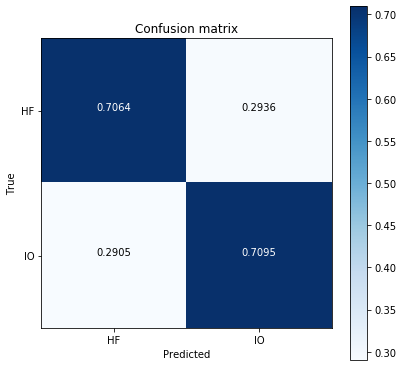

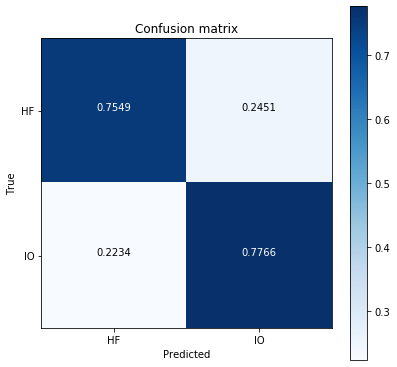

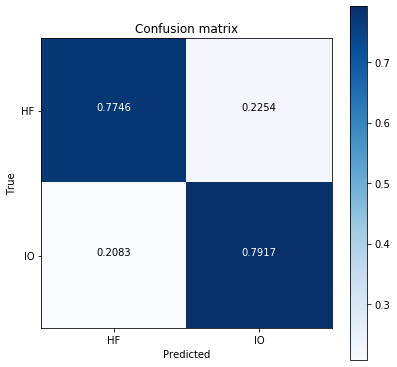

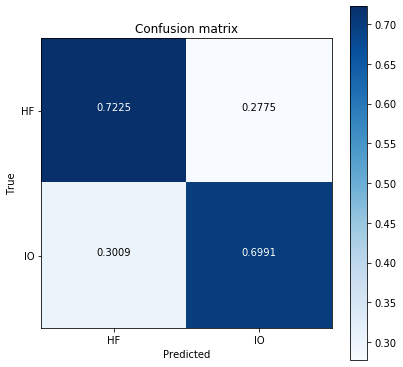

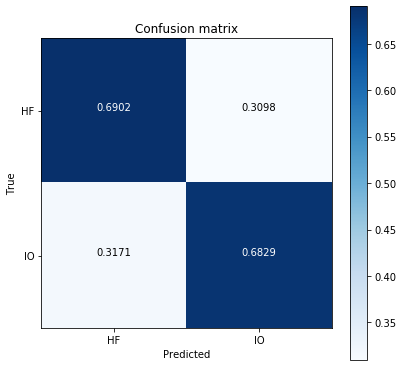

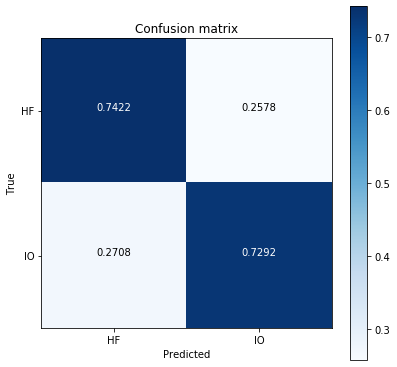

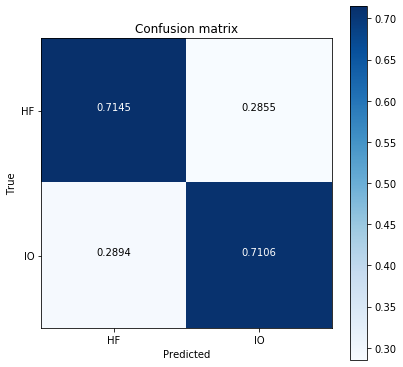

In [30]:
X_temporal = X_hf_io_3d.copy()
X_temporal = np.transpose(X_temporal, (1, 2, 0))                # 32 x 2*864 x 124

keep_cm = []
 
for i in range(0,25,3):                                         # for each time window
    X = np.concatenate((X_temporal[i], X_temporal[i+1], X_temporal[i+2], X_temporal[i+3], X_temporal[i+4]), axis=1)
    
    X -= np.mean(X, axis=0)                                     # svd
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X,v,y_hf_io, 2)        # use lda function to find the accuracy and the cm
    
    print("Final Accuracy of time window {}-{} is: {:.3%}" .format(i, i+4, final_accuracy))
    
    keep_cm.append(cm_cv)
    
    plot_cm(np.round(cm_cv, 4),2)

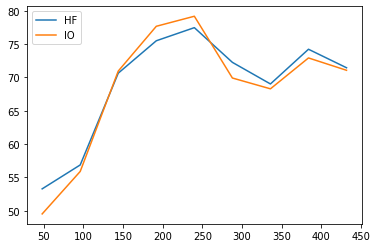

In [31]:
diag = []

for i in range(0,2):
    diag_cm = [ (keep_cm[j][i][i]*100) for j in range(len(keep_cm)) ]
    diag.append(diag_cm)

legends = ["HF", "IO"]

x = np.arange(48, 433,48)
        
for i in range(0,2):
    plt.plot(x, diag[i])

plt.legend(legends, loc='upper left')

plt.show()

### Spatial and Temporal Subsets

In [32]:
X_sp_temp = X_hf_io_3d.copy()
X_sp_temp = np.transpose(X_sp_temp, (1, 0, 2))                 # 32 x 124 x 2*864

spatial_temporal_accuracy = np.zeros((9,124))
length = len(X_sp_temp[0][0])
r = 0

for i in range(0,25,3):                                        # for each time window
    for j in range(0,124):                                     # for each electrode
        X = np.concatenate((np.reshape(X_sp_temp[i,j], (length,1)), np.reshape(X_sp_temp[i+1,j], (length,1)), 
                            np.reshape(X_sp_temp[i+2,j], (length,1)), np.reshape(X_sp_temp[i+3,j], (length,1)), 
                            np.reshape(X_sp_temp[i+4,j], (length,1))), axis=1)
         
        X -= np.mean(X, axis=0)                                # svd
        [u,s,v] = la.svd(X)  
        v = v.transpose() 
    
        final_accuracy, cm_cv = lda_function(X, v, y_hf_io, 2) # use lda function to find the accuracy and the cm
        spatial_temporal_accuracy[r,j] = final_accuracy
    
        print("Final Accuracy of time window {}-{} and electrode {} is : {:.3%}" .format(i, i+4, j, final_accuracy))
    
        # plot_cm(np.round(cm_cv, 4),2)
    r = r+1

Final Accuracy of time window 0-4 and electrode 0 is : 49.395%
Final Accuracy of time window 0-4 and electrode 1 is : 50.029%
Final Accuracy of time window 0-4 and electrode 2 is : 50.497%
Final Accuracy of time window 0-4 and electrode 3 is : 50.667%
Final Accuracy of time window 0-4 and electrode 4 is : 48.119%
Final Accuracy of time window 0-4 and electrode 5 is : 50.434%
Final Accuracy of time window 0-4 and electrode 6 is : 51.419%
Final Accuracy of time window 0-4 and electrode 7 is : 49.739%
Final Accuracy of time window 0-4 and electrode 8 is : 50.608%
Final Accuracy of time window 0-4 and electrode 9 is : 50.839%
Final Accuracy of time window 0-4 and electrode 10 is : 49.681%
Final Accuracy of time window 0-4 and electrode 11 is : 50.028%
Final Accuracy of time window 0-4 and electrode 12 is : 50.087%
Final Accuracy of time window 0-4 and electrode 13 is : 50.667%
Final Accuracy of time window 0-4 and electrode 14 is : 49.800%
Final Accuracy of time window 0-4 and electrode 15

## Exemplar-Level Classifications

In [33]:
X3 = X_2D.copy()
y3 = exemplarLabels.ravel()
# Let us assume that it is centered
X3 -= np.mean(X3, axis=0)                                # svd
[u,s,v] = la.svd(X3) 
v = v.transpose() 

Total time of classification process using LDA: 2456.3720874786377 seconds

Final Accuracy is: 10.046%


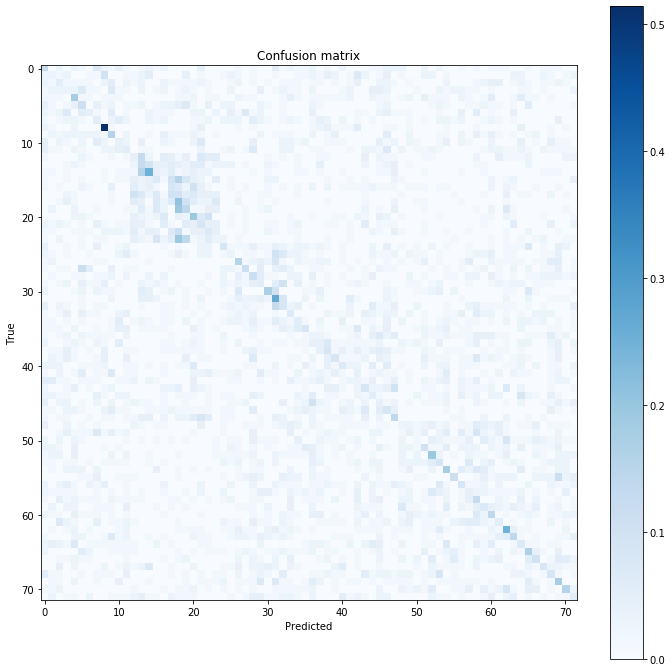

In [34]:
start_time = time.time()

lda_accuracy, lda_cm = lda_function(X3, v, y3,72)        # use lda function to find the accuracy and the cm

print("Total time of classification process using LDA: %s seconds" % (time.time() - start_time))
print("\nFinal Accuracy is: {:.3%}" .format(lda_accuracy))  
plot_cm(np.round(lda_cm, 4),72)

### Temporal Subsets

Final Accuracy of time window 0-4 is: 1.408%
Final Accuracy of time window 3-7 is: 1.620%
Final Accuracy of time window 6-10 is: 4.377%
Final Accuracy of time window 9-13 is: 8.330%
Final Accuracy of time window 12-16 is: 9.622%
Final Accuracy of time window 15-19 is: 8.060%
Final Accuracy of time window 18-22 is: 5.842%
Final Accuracy of time window 21-25 is: 4.647%
Final Accuracy of time window 24-28 is: 3.664%


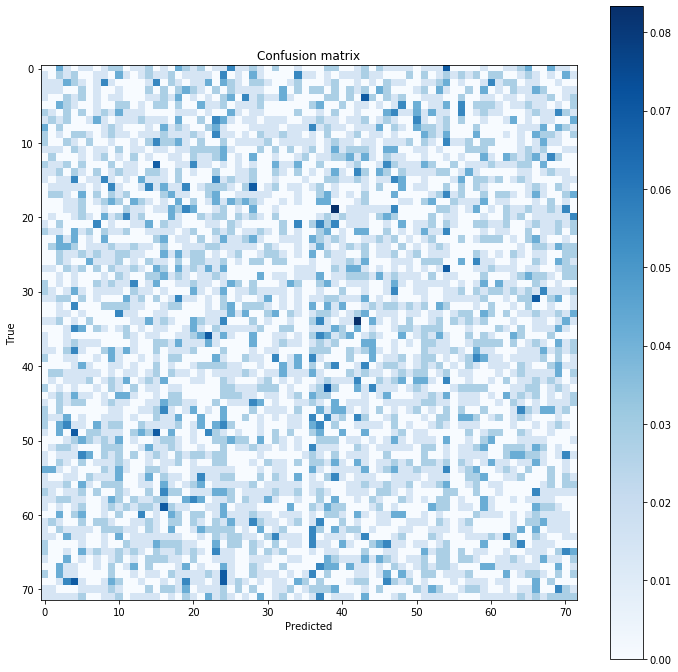

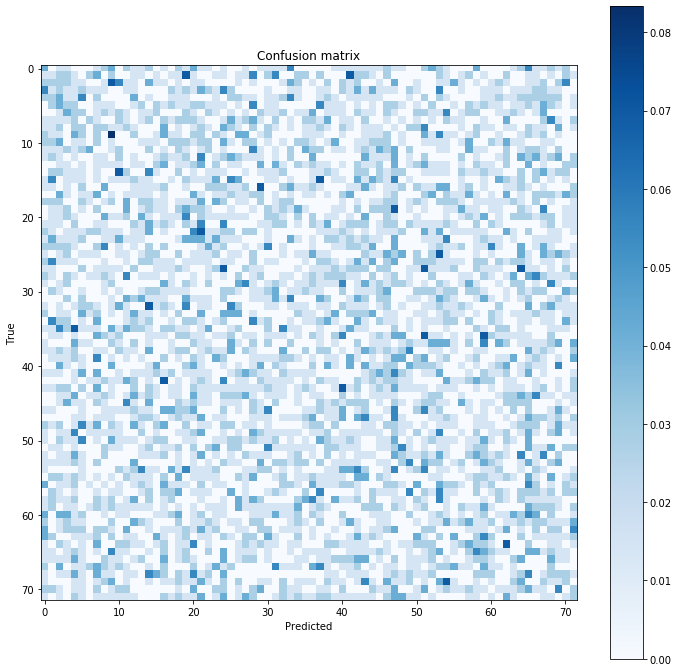

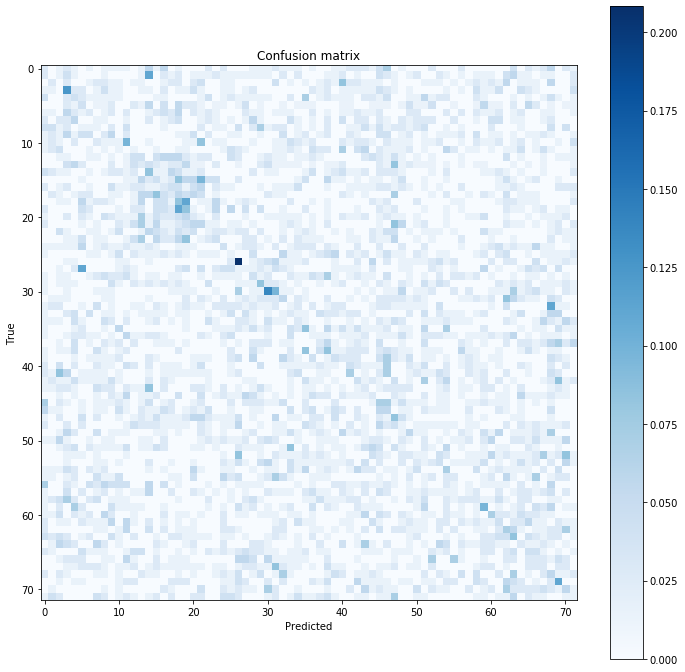

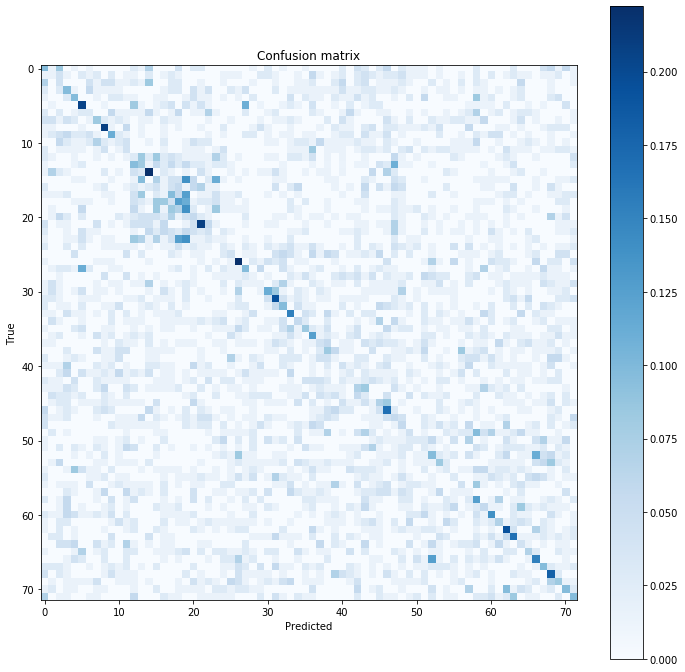

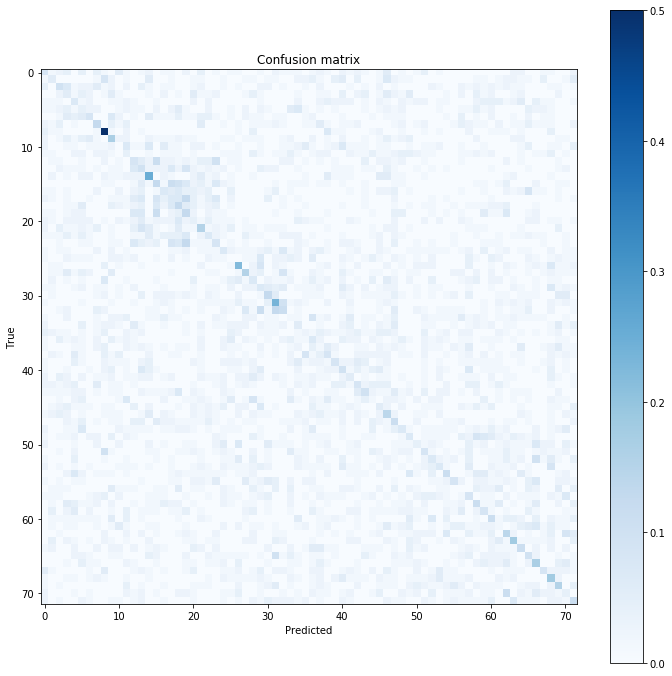

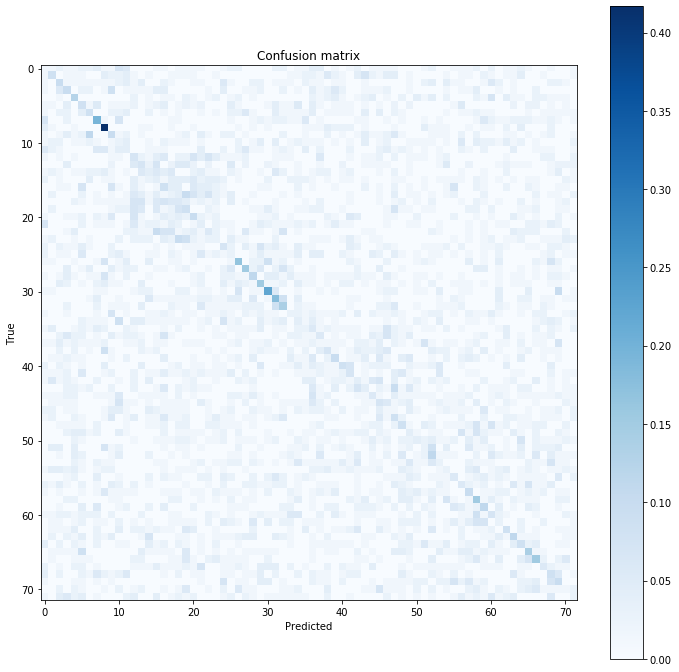

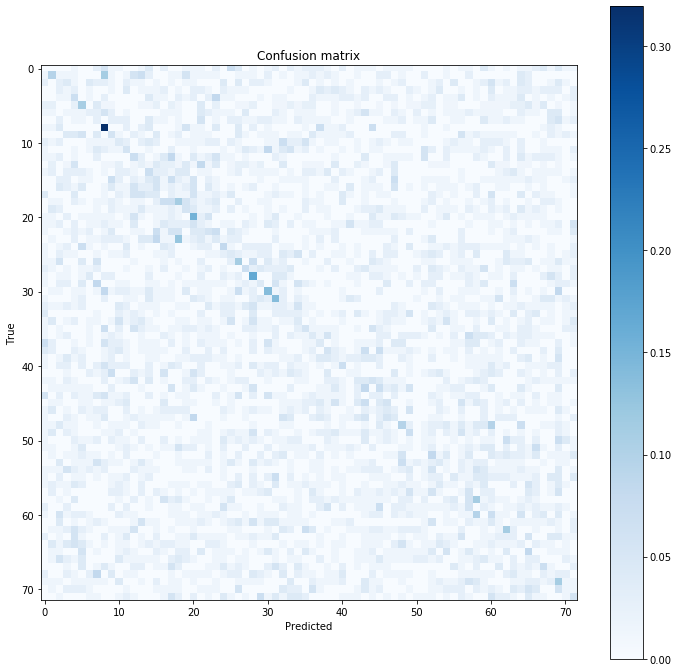

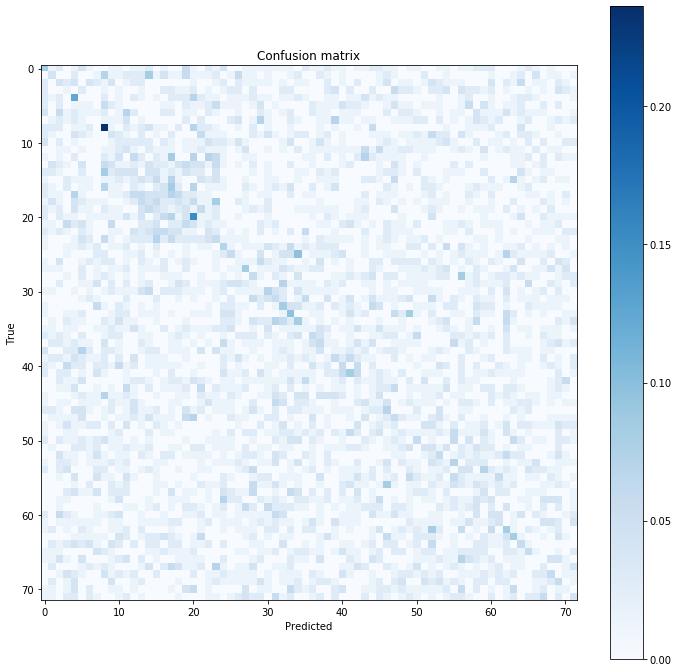

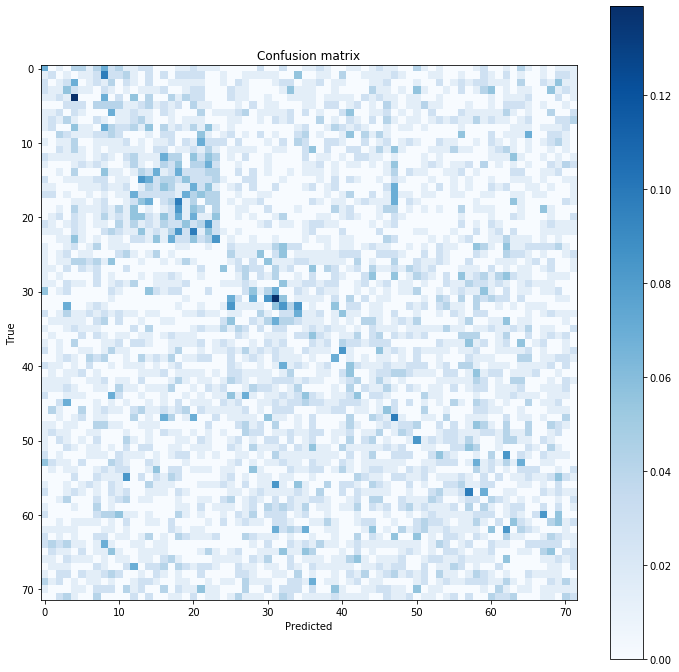

In [35]:
X_temporal = X_3D.copy()
X_temporal = np.transpose(X_temporal, (1, 2, 0))                # 32 x 5184 x 124

keep_cm = []

for i in range(0,25,3):                                         # for each time window
    X = np.concatenate((X_temporal[i], X_temporal[i+1], X_temporal[i+2], X_temporal[i+3], X_temporal[i+4]), axis=1)
    
    X -= np.mean(X, axis=0)                                     # svd
    [u,s,v] = la.svd(X) 
    v = v.transpose() 
    
    final_accuracy, cm_cv = lda_function(X,v,y3,72)             # use lda function to find the accuracy and the cm
    
    print("Final Accuracy of time window {}-{} is: {:.3%}" .format(i, i+4, final_accuracy))
    
    keep_cm.append(cm_cv)
    
    plot_cm(np.round(cm_cv, 4),72)

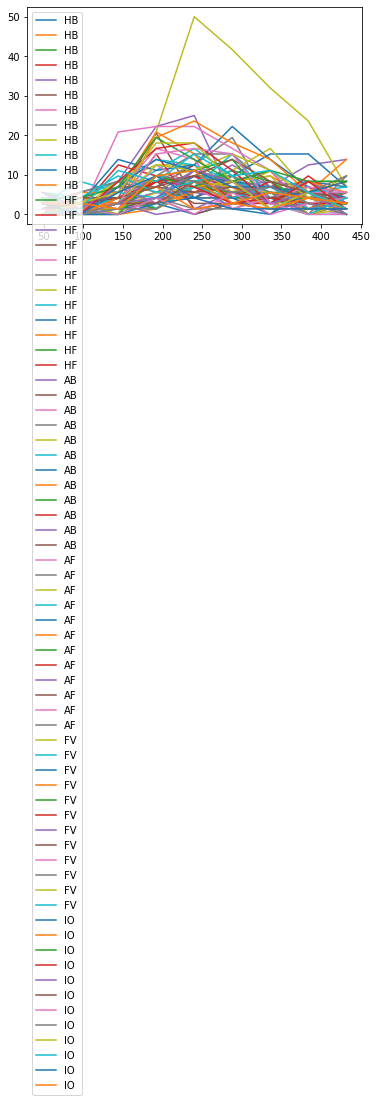

In [36]:
diag = []

for i in range(0,72):
    diag_cm = [ (keep_cm[j][i][i]*100) for j in range(len(keep_cm)) ]
    diag.append(diag_cm)

legends = []

for i in range(0,72):
    if i < 12 :
        legends.append("HB")
    elif i < 24 :
        legends.append("HF")
    elif i < 36 :
        legends.append("AB")
    elif i < 48 :
        legends.append("AF")
    elif i < 60 :
        legends.append("FV")
    else:
        legends.append("IO")

x = np.arange(48, 433,48)
        
for i in range(0,72):
    plt.plot(x, diag[i])

plt.legend(legends, loc='upper left')

plt.show()